In [9]:
from pyexpat import features

import pandas as pd
import os

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

In [13]:
def compute_score(x_home, x_away, y_outcome):
    """Compute kicktipp score based on the outcome of a football match.

    Args:
        x_home (int): Predicted number of goals scored by the home team.
        x_away (int): Predicted number of goals scored by the away team.
        y_outcome (str): Actual outcome of the match in the format "x:y".

    Returns:
        int: Kicktipp score for the match.
            3: Correct outcome and correct score
            1: Correct outcome
        """
    y_home, y_away = y_outcome.split(':')
    y_home, y_away = int(y_home), int(y_away)
    type(y_away)
    if x_home == y_home and x_away == y_away:
        return 3
    elif (x_home > x_away and y_home > y_away) or (x_home < x_away and y_home < y_away) or (x_home == x_away and y_home == y_away):
        return 1
    else:
        return 0

def predict_outcome(odds_home, odds_away):
    """Predict the outcome of a football match based on the odds of a bookmaker.

    Args:
        odds_home (float): Odds for the home team to win.
        odds_away (float): Odds for the away team to win.

    Returns:
        str: Predicted outcome of the match in the format "x:y".
    """
    if odds_home < odds_away:
        return "2:1"
    elif odds_home > odds_away:
        return "1:2"
    else:
        return "1:1"

In [18]:
# features = ['B365H', 'B365D', 'B365A', 'B365<2.5', 'B365>2.5'] # 123
features = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'B365<2.5', 'B365>2.5']
# features = ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'B365<2.5', 'B365>2.5']

def get_features(df):
    df_return = df.loc[:, features]
    df_return.rename(columns={'B365<2.5': 'B365U', 'B365>2.5': 'B365O'}, inplace=True)
    return df_return

def get_targets(df):
    return df.loc[:, ['FTHG', 'FTAG']]

In [12]:
path = '../data/football-data.co.uk'
files = os.listdir(path)
files

['BL25.csv', 'BL24.csv', 'BL20.csv', 'BL21.csv', 'BL23.csv', 'BL22.csv']

In [14]:
df_target = pd.read_csv(f'{path}/{files[0]}')
X_test = get_features(df_target)

df_target

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,D1,22/08/2025,19:30,Bayern Munich,RB Leipzig,6,0,H,3,0,...,1.98,1.88,1.98,1.93,1.99,1.93,1.90,1.86,2.07,1.92
1,D1,23/08/2025,14:30,Ein Frankfurt,Werder Bremen,4,1,H,2,0,...,1.83,2.03,2.02,1.91,1.91,2.03,1.83,1.93,1.91,2.06
2,D1,23/08/2025,14:30,Freiburg,Augsburg,1,3,A,0,3,...,1.93,1.93,1.97,1.95,1.97,1.93,1.90,1.86,2.03,1.96
3,D1,23/08/2025,14:30,Heidenheim,Wolfsburg,1,3,A,1,1,...,2.03,1.83,2.06,1.87,2.03,1.85,1.97,1.81,2.12,1.88
4,D1,23/08/2025,14:30,Leverkusen,Hoffenheim,1,2,A,1,1,...,1.98,1.88,1.97,1.95,1.98,2.02,1.88,1.86,2.00,1.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,D1,08/11/2025,14:30,Union Berlin,Bayern Munich,2,2,D,1,1,...,1.85,2.00,1.91,2.00,1.87,2.00,1.82,1.95,1.92,2.08
86,D1,08/11/2025,17:30,M'gladbach,FC Koln,3,1,H,1,0,...,2.03,1.83,2.08,1.85,2.08,1.83,2.02,1.76,2.12,1.88
87,D1,09/11/2025,14:30,Freiburg,St Pauli,2,1,H,1,0,...,2.00,1.85,2.03,1.90,2.04,1.85,1.99,1.79,2.05,1.93
88,D1,09/11/2025,16:30,Stuttgart,Augsburg,3,2,H,2,2,...,1.88,1.98,1.85,2.08,1.88,2.00,1.81,1.97,1.90,2.08


In [15]:
dfs = pd.DataFrame()
for file in files[1:]:
    print(file)
    dfs = pd.concat([dfs, pd.read_csv(f'{path}/{file}')], axis=0)

dfs

BL24.csv
BL20.csv
BL21.csv
BL23.csv
BL22.csv


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,IWA,VCH,VCD,VCA,IWCH,IWCD,IWCA,VCCH,VCCD,VCCA
0,D1,23/08/2024,19:30,M'gladbach,Leverkusen,2,3,A,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D1,24/08/2024,14:30,Augsburg,Werder Bremen,2,2,D,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D1,24/08/2024,14:30,Freiburg,Stuttgart,3,1,H,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D1,24/08/2024,14:30,Hoffenheim,Holstein Kiel,3,2,H,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D1,24/08/2024,14:30,Mainz,Union Berlin,1,1,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,D1,27/05/2023,14:30,M'gladbach,Augsburg,2,0,H,2.0,0.0,...,3.15,2.15,3.90,3.0,2.00,3.65,3.60,2.00,4.0,3.40
302,D1,27/05/2023,14:30,RB Leipzig,Schalke 04,4,2,H,2.0,1.0,...,4.70,1.60,4.60,4.8,1.55,5.00,4.90,1.50,5.0,5.50
303,D1,27/05/2023,14:30,Stuttgart,Hoffenheim,1,1,D,0.0,0.0,...,5.50,1.57,4.60,5.0,1.50,5.00,5.75,1.50,4.8,5.75
304,D1,27/05/2023,14:30,Union Berlin,Werder Bremen,1,0,H,0.0,0.0,...,7.25,1.44,4.75,7.0,1.43,4.90,6.75,1.50,4.6,6.00


In [19]:
X_train = get_features(dfs)
y_train = get_targets(dfs)

In [23]:
df_target.apply(lambda x: compute_score(x['FTHG'], x['FTAG'], "2:1"), axis=1).sum()

np.int64(59)

In [24]:
df_target["pred0"] = df_target.apply(lambda x: predict_outcome(x['B365H'], x['B365A']), axis=1)
df_target.apply(lambda x: compute_score(x['FTHG'], x['FTAG'], x['pred0']), axis=1).sum()

np.int64(70)

In [25]:
# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Wrap the regressor with MultiOutputRegressor
multi_output_regressor = MultiOutputRegressor(xgb_regressor, en)

# Train the model
multi_output_regressor.fit(X_train, y_train)

# Predict multiple target values
y_pred = multi_output_regressor.predict(X_test)
y_pred

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:HomeTeam: object, AwayTeam: object

In [26]:
# round and join two columns of y_pred as a string
df_target['pred1'] = y_pred[:, 0].round().astype(int).astype(str) + ':' + y_pred[:, 1].round().astype(int).astype(str)
df_target.apply(lambda x: compute_score(x['FTHG'], x['FTAG'], x['pred1']), axis=1).sum()

NameError: name 'y_pred' is not defined

In [24]:
y_train

,FTHG,FTAG
0,8,0
1,1,1
2,2,3
3,2,3
4,1,3
...,...,...
301,2,0
302,4,2
303,1,1
304,1,0


In [22]:
df_target

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA,pred0,pred1
0,D1,23/08/2024,19:30,M'gladbach,Leverkusen,2,3,A,0,2,...,1.87,2.06,1.96,2.08,1.91,1.96,1.91,2.07,1:2,2:2
1,D1,24/08/2024,14:30,Augsburg,Werder Bremen,2,2,D,2,1,...,1.88,2.04,1.88,2.06,1.86,2.03,1.90,2.10,2:1,2:0
2,D1,24/08/2024,14:30,Freiburg,Stuttgart,3,1,H,1,1,...,1.95,1.97,1.98,2.09,1.87,2.00,1.95,2.04,1:2,1:1
3,D1,24/08/2024,14:30,Hoffenheim,Holstein Kiel,3,2,H,2,0,...,1.99,1.93,2.16,1.95,2.02,1.86,2.00,1.95,2:1,2:1
4,D1,24/08/2024,14:30,Mainz,Union Berlin,1,1,D,0,0,...,2.11,1.83,2.13,1.85,2.07,1.81,2.18,1.84,2:1,2:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,D1,08/03/2025,14:30,Leverkusen,Werder Bremen,0,2,A,0,1,...,1.97,1.95,2.03,1.97,1.96,1.90,2.01,1.98,2:1,2:0
221,D1,08/03/2025,14:30,Wolfsburg,St Pauli,1,1,D,0,1,...,1.86,2.07,1.89,2.07,1.84,2.03,1.86,2.14,2:1,1:1
222,D1,08/03/2025,17:30,Freiburg,RB Leipzig,0,0,D,0,0,...,1.83,2.11,1.87,2.11,1.83,2.04,1.89,2.10,2:1,2:1
223,D1,09/03/2025,14:30,Ein Frankfurt,Union Berlin,1,2,A,1,0,...,2.00,1.93,2.04,1.93,1.98,1.87,2.02,1.96,2:1,1:1


In [11]:
df['H'] = df['FTR'].apply(lambda x: 1 if x == 'H' else 0)
df['A'] = df['FTR'].apply(lambda x: 1 if x == 'A' else 0)
df['D'] = df['FTR'].apply(lambda x: 1 if x == 'D' else 0)
df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA,pred0,H,A,D
0,D1,2024-08-23 19:30:00,M'gladbach,Leverkusen,2,3,A,0,2,A,...,1.96,2.08,1.91,1.96,1.91,2.07,1:2,0,1,0
1,D1,2024-08-24 14:30:00,Augsburg,Werder Bremen,2,2,D,2,1,H,...,1.88,2.06,1.86,2.03,1.90,2.10,2:1,0,0,1
2,D1,2024-08-24 14:30:00,Freiburg,Stuttgart,3,1,H,1,1,D,...,1.98,2.09,1.87,2.00,1.95,2.04,1:2,1,0,0
3,D1,2024-08-24 14:30:00,Hoffenheim,Holstein Kiel,3,2,H,2,0,H,...,2.16,1.95,2.02,1.86,2.00,1.95,2:1,1,0,0
4,D1,2024-08-24 14:30:00,Mainz,Union Berlin,1,1,D,0,0,D,...,2.13,1.85,2.07,1.81,2.18,1.84,2:1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,D1,2025-03-08 14:30:00,Leverkusen,Werder Bremen,0,2,A,0,1,A,...,2.03,1.97,1.96,1.90,2.01,1.98,2:1,0,1,0
221,D1,2025-03-08 14:30:00,Wolfsburg,St Pauli,1,1,D,0,1,A,...,1.89,2.07,1.84,2.03,1.86,2.14,2:1,0,0,1
222,D1,2025-03-08 17:30:00,Freiburg,RB Leipzig,0,0,D,0,0,D,...,1.87,2.11,1.83,2.04,1.89,2.10,2:1,0,0,1
223,D1,2025-03-09 14:30:00,Ein Frankfurt,Union Berlin,1,2,A,1,0,H,...,2.04,1.93,1.98,1.87,2.02,1.96,2:1,0,1,0


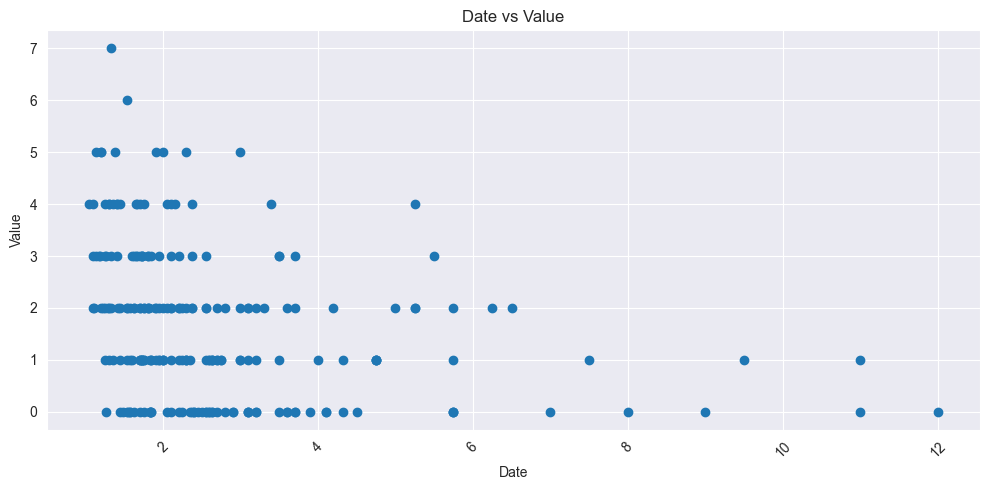

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(df['B365H'], df['FTHG'])  # Replace 'Value' with the column you want to plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Date vs Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Compute the correlation matrix
correlation_matrix = df.corr(numeric_only=True).iloc[:, -3:]
correlation_matrix

,H,A,D
FTHG,0.700679,-0.525606,-0.222196
FTAG,-0.446852,0.611260,-0.165916
HTHG,0.551988,-0.394024,-0.197379
HTAG,-0.365073,0.459643,-0.091257
HS,0.210148,-0.186575,-0.034398
...,...,...,...
BFECAHH,-0.052299,0.058240,-0.004597
BFECAHA,0.024194,-0.051787,0.029812
H,1.000000,-0.611425,-0.471686
A,-0.611425,1.000000,-0.409343


In [20]:
correlation_matrix.head(2)

,H,A,D
FTHG,0.700679,-0.525606,-0.222196
FTAG,-0.446852,0.611260,-0.165916


In [18]:

# Optionally, visualize the correlation matrix using a heatmap
plt.figure(figsize=(100, 4))
sns.heatmap(correlation_matrix.head(2).iloc[:, 6:], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 10000x400 with 0 Axes>